In [42]:
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### Read in Data

In [2]:
data = np.load("../data/matrix.npy")

In [132]:
beta_data = 1.0 * np.ones(beta_data.shape)
gamma_data = 0.01 * np.ones(beta_data.shape)
S_init_data = data[:, :, 2]
I_init_data = data[:, :, 3]
R_init_data = data[:, :, 4]
isUS_data = data[:, :, 5]

dS_data = 0.01 * np.ones(beta_data.shape)
dI_data = 0.5 * np.ones(beta_data.shape)
dR_data = 0.01 * np.ones(beta_data.shape)
dS_data[isUS_data == 0] = 0
dI_data[isUS_data == 0] = 0
dR_data[isUS_data == 0] = 0

In [110]:
beta_data = data[:, :, 0]*200
gamma_data = data[:, :, 1]/100
S_init_data = data[:, :, 2]
I_init_data = data[:, :, 3]
R_init_data = data[:, :, 4]
isUS_data = data[:, :, 5]

dS_data = 0.01 * np.ones(beta_data.shape)
dI_data = 0.5 * np.ones(beta_data.shape)
dR_data = 0.01 * np.ones(beta_data.shape)
dS_data[isUS_data == 0] = 0
dI_data[isUS_data == 0] = 0
dR_data[isUS_data == 0] = 0

In [115]:
np.max(beta_data)

3.364828732475792

In [140]:
np.savetxt('../data/beta.csv', beta_data, delimiter=',')
np.savetxt('../data/gamma.csv', gamma_data, delimiter=',')
np.savetxt('../data/S_init.csv', S_init_data, delimiter=',')
np.savetxt('../data/I_init.csv', I_init_data, delimiter=',')
np.savetxt('../data/R_init.csv', R_init_data, delimiter=',')
np.savetxt('../data/dS.csv', dS_data, delimiter=',')
np.savetxt('../data/dI.csv', dI_data, delimiter=',')
np.savetxt('../data/dR.csv', dR_data, delimiter=',')

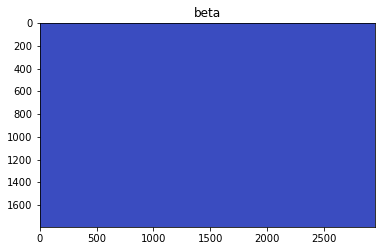

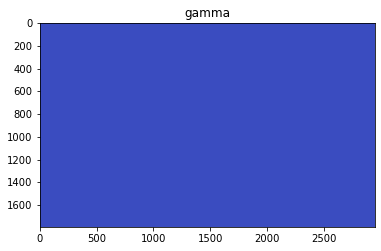

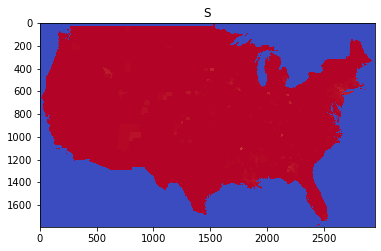

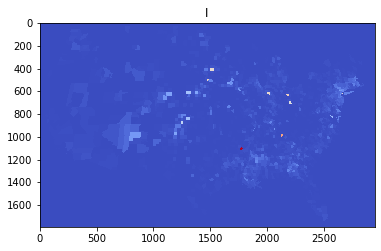

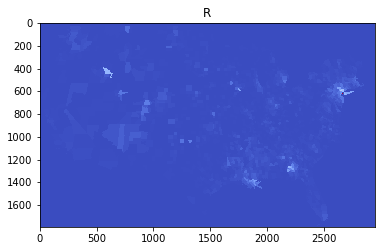

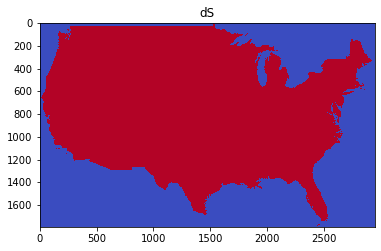

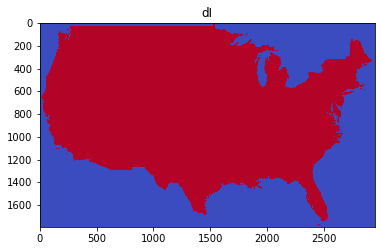

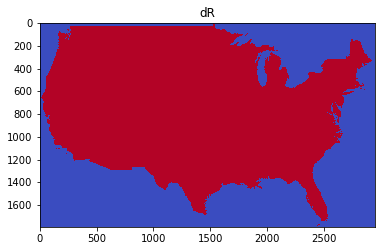

In [133]:
titles=['beta', 'gamma', 'S', 'I', 'R', 'dS', 'dI', 'dR']
data_arr=[beta_data, gamma_data, S_init_data, I_init_data, R_init_data, dS_data, dI_data, dR_data]
for i in range(len(data_arr)):
    plt.figure(i)
    plt.imshow(data_arr[i], cmap='coolwarm')
    plt.title(titles[i])

### Temporal SIR model

In [62]:
def SIR_temporal_simulate(params):
    
    def forward_euler(current, beta, gamma):
        '''Implement simple forward Euler ODE solving.'''

        S_current, I_current, R_current = current
        S_next = S_current - beta*S_current*I_current
        I_next = I_current + beta*S_current*I_current - gamma*I_current
        R_next = R_current + gamma*I_current

        return [S_next, I_next, R_next]
    
    #Time to simulate for, transmission rate, recovery rate
    Tmax, beta, gamma = params['Tmax'], params['beta'], params['gamma']
    #Create solution array
    solution = np.empty((Tmax+1, 3))
    #Initialise for t=0
    solution[0] = [params['S_init'], params['I_init'], params['R_init']]

    for t in range(Tmax):
        solution[t+1] = forward_euler(solution[t], beta, gamma)
        
    plt.figure(figsize=(8,5))
    plt.plot(solution[:, 0], label='S')
    plt.plot(solution[:, 1], label='I')
    plt.plot(solution[:, 2], label='R')
    plt.legend()
    plt.title(f'Simulation for {Tmax} timesteps\nbeta={beta}, gamma={gamma}, init={solution[0]}')
    plt.xlabel('Time')
    plt.show()

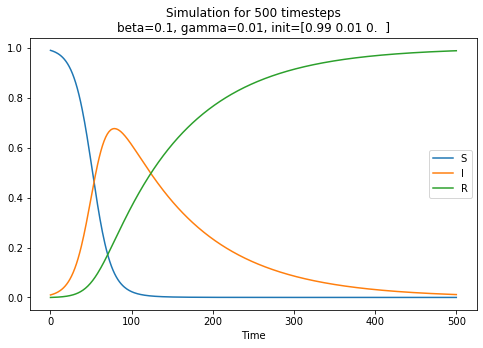

In [63]:
params={
    'beta':0.1,
    'gamma':0.01,
    'S_init':0.99,
    'I_init':0.01,
    'R_init':0.0,
    'Tmax':500
}

SIR_temporal_simulate(params)

### Spatio-temporal SIR model

In [7]:
def SIR_spatio_temporal_simulate(params):
    
    def forward_euler_spatial(current, beta, gamma, dS, dI, dR, Xmax, Ymax):
        '''Implement simple forward Euler ODE solving
        with spatial diffusion terms.'''

        S_current, I_current, R_current = current
        
        S_next = S_current.copy()
        I_next = I_current.copy()
        R_next = R_current.copy()
        

        for i in range(1, Ymax-1):
            for j in range(1, Xmax-1):
                S_next[i,j] = S_current[i,j] - beta[i,j]*S_current[i,j]*I_current[i,j] + \
                    dS[i,j] * (S_current[i+1, j] + S_current[i-1, j] - 4*S_current[i, j] + S_current[i, j+1] + S_current[i, j-1])
                I_next[i,j] = I_current[i,j] + beta[i,j]*S_current[i,j]*I_current[i,j] - gamma[i,j]*I_current[i,j] + \
                    dI[i,j] * (I_current[i+1, j] + I_current[i-1, j] - 4*I_current[i, j] + I_current[i, j+1] + I_current[i, j-1])
                R_next[i,j] = R_current[i,j] + gamma[i,j]*I_current[i,j] + \
                    dR[i,j] * (R_current[i+1, j] + R_current[i-1, j] - 4*R_current[i, j] + R_current[i, j+1] + R_current[i, j-1])

        return [S_next, I_next, R_next]
    
    #Time to simulate for, transmission rate, recovery rate
    Tmax, Xmax, Ymax = params['Tmax'], params['Xmax'], params['Ymax']
    beta, gamma, dS, dI, dR = params['beta'], params['gamma'], params['dS'], params['dI'], params['dR']
    #Create solution array
    solution = np.empty((Tmax+1, 3, Ymax, Xmax))
    #Initialise for t=0
    solution[0] = np.array([params['S_init'], params['I_init'], params['R_init']])

    for t in range(Tmax):
        solution[t+1] = forward_euler_spatial(solution[t], beta, gamma, dS, dI, dR, Xmax, Ymax)

    return solution

In [140]:
Xmax = 294
Ymax = 179

R_init = np.zeros((Ymax, Xmax))
I_init = np.zeros((Ymax, Xmax))
I_init[int(0.15*Xmax):int(0.35*Xmax), int(0.8*Xmax):int(0.95*Xmax)] = 0.1
S_init = 1-I_init

dS = 0.01 * np.ones((Ymax, Xmax))
dI = 0.1 * np.ones((Ymax, Xmax))
dR = 0.01 * np.ones((Ymax, Xmax))
dS[1-isUS_data.astype('int')] = 0
dI[1-isUS_data.astype('int')] = 0
dR[1-isUS_data.astype('int')] = 0

params={
    'beta':beta_data,
    'gamma':gamma_data,
    'S_init':S_init,
    'I_init':I_init,
    'R_init':R_init,
    'Tmax':5,
    'Xmax':Xmax,
    'Ymax':Ymax,
    'dS':dS,
    'dI':dI,
    'dR':dR
}

solution = SIR_spatio_temporal_simulate(params)

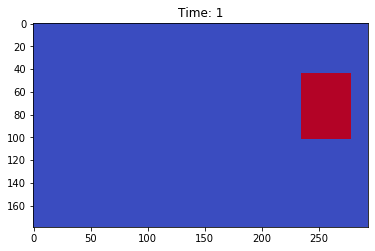

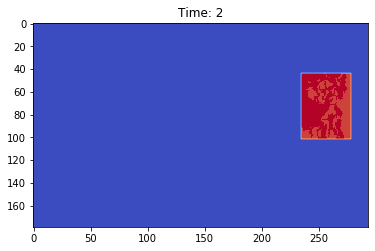

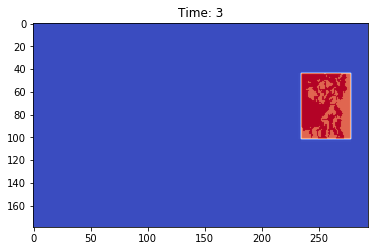

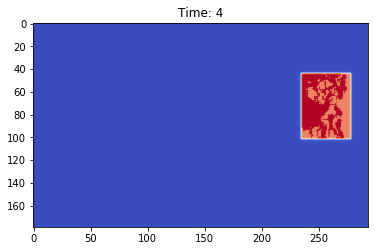

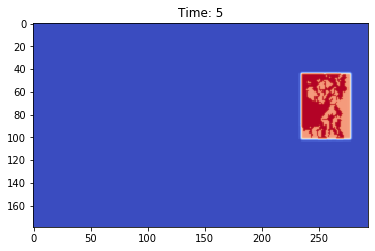

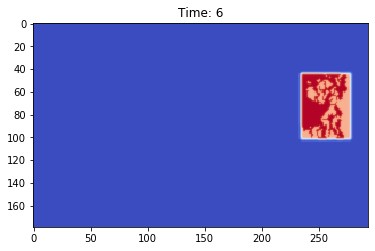

In [141]:
for i in range(solution.shape[0]):
#     if i % 10 == 0: 
    plt.figure(i)
    plt.imshow(solution[i,1], cmap='coolwarm')
    plt.title(f'Time: {i+1}')
    plt.show()
    plt.close()

### Agent based model

In [221]:
def random_walk(current, sigma):
    '''Simulate one time step of random walk.'''
    new = current + sigma*np.random.randn(current.shape[0], current.shape[1])
    new[new > 1]=1
    new[new < 0]=0
    return new

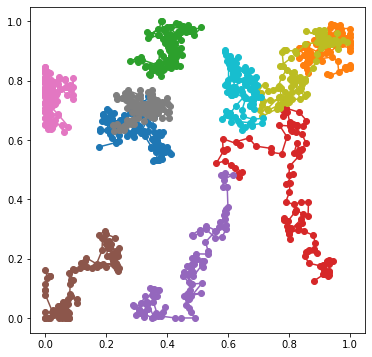

In [227]:
n_people = 10
Tmax = 100
coords = np.expand_dims(np.random.rand(n_people,2), axis=0)
for i in range(Tmax):
    new = np.expand_dims(random_walk(coords[i], 0.02), axis=0)
    coords = np.concatenate((coords, new), axis=0)
plt.figure(figsize=(6,6))
for i in range(n_people):
    plt.plot(coords[:, i, 0], coords[:, i, 1], '-o')

### Processor Scaling

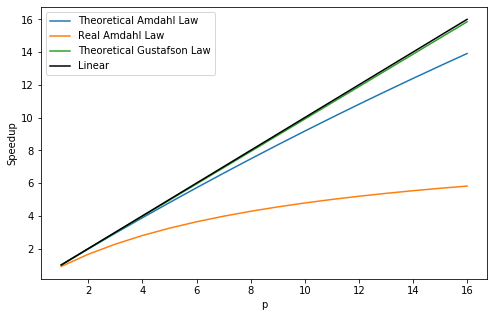

In [28]:
p = np.linspace(1,16,16)
S_am = 1/(0.01 + 0.99/p )
S_am_real = 1/(0.01 + 0.99/p +0.1)
S_gu = 1-0.99+0.99*p
plt.figure(figsize=(8,5))
plt.plot(p, S_am, label="Theoretical Amdahl Law")
plt.plot(p, S_am_real, label="Real Amdahl Law")
plt.plot(p, S_gu, label="Theoretical Gustafson Law")
plt.plot(p, p, 'k',label='Linear')
plt.legend()
plt.xlabel('p')
plt.ylabel('Speedup')
plt.savefig('scaling.png')

### Algorithmic Complexity

In [62]:
d = [100, 200, 500, 1000, 2000]
t = [20, 50, 100, 200]
results_t = [0.0065, 0.015, 0.029, 0.057] #100 x 100
results_d = [0.029666, 0.134002, 0.848304, 3.81878, 17.6717] #100

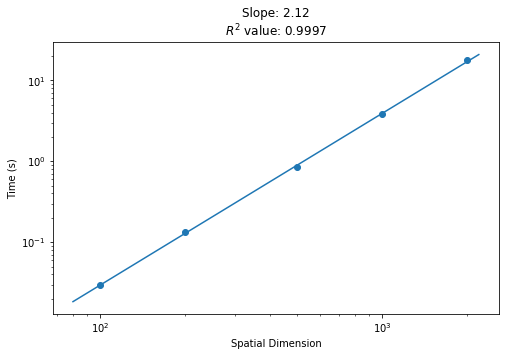

In [101]:
plt.figure(figsize=(8,5))
x = np.log(d)
y = np.log(results_d)
plt.scatter(d, results_d)
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
d_plot = np.linspace(80, 2200, 100)
plt.plot(d_plot, np.exp(intercept)*(d_plot**slope))
plt.title(f'Slope: {slope:.3}\n$R^2$ value: {r_value**2:.4}')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Spatial Dimension')
plt.ylabel('Time (s)')
plt.savefig('../results/spatial_scaling.png')

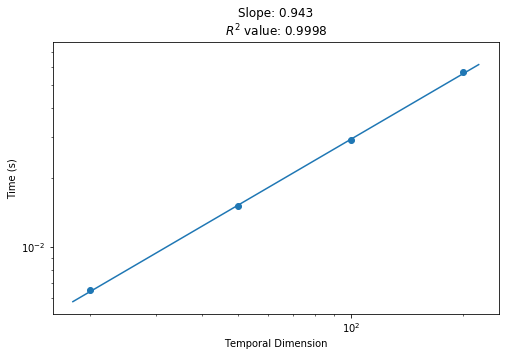

In [102]:
plt.figure(figsize=(8,5))
x = np.log(t)
y = np.log(results_t)
plt.scatter(t, results_t)
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
t_plot = np.linspace(18, 220, 100)
plt.plot(t_plot, np.exp(intercept)*(t_plot**slope))
plt.title(f'Slope: {slope:.3}\n$R^2$ value: {r_value**2:.4}')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Temporal Dimension')
plt.ylabel('Time (s)')
plt.savefig('../results/temporal_scaling.png')

In [163]:
output = np.loadtxt('../results/output')
output.shape

(1792, 2944)

In [164]:
np.min(output), np.max(output), np.mean(output), np.mean(I_init_data)

(0.0, 1.18685, 0.1462408848133462, 0.00032977851975392813)

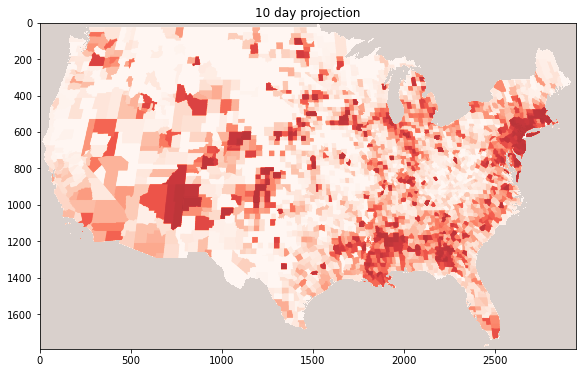

In [193]:
sigmoid = lambda x: 1/(1+np.exp(-x))

plt.figure(figsize=(10,int(1792/2944*10)))
plt.imshow(sigmoid(output), cmap='Reds')
plt.imshow(isUS_data, cmap='gray', alpha=0.15)
plt.title('10 day projection')
plt.show()

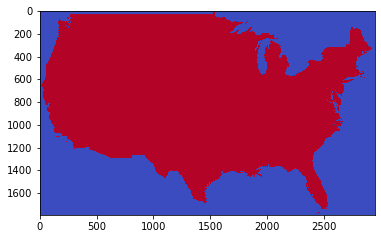

In [171]:
# plt.figure(figsize=(8,6))
plt.imshow(dS_data, cmap='coolwarm')
plt.show()

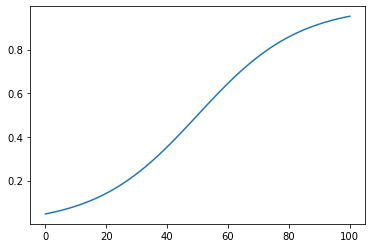

In [161]:
plt.plot(sigmoid(np.linspace(-3,3,101)))